# Text preprocessing

In [2]:
DATA = "data/"
TRAIN = f"{DATA}/train.csv"
TEST = f"{DATA}/test.csv"
TRAIN_LABEL = f"{DATA}/train_label.txt"
TRAIN_TITLE = f"{DATA}/train_title.txt"
TRAIN_TEXT = f"{DATA}/train_text.txt"
TEST_LABEL = f"{DATA}/test_label.txt"
TEST_TITLE= f"{DATA}/test_title.txt"
TEST_TEXT = f"{DATA}/test_text.txt"

TRAIN_NORM = f"{DATA}/train_norm.txt"
TEST_NORM = f"{DATA}/test_norm.txt"

In [3]:
# # Splt the csv into label, title, text
# import pandas as pd

# train = pd.read_csv(TRAIN)
# train_col = train.columns
# train[train_col[0]].to_csv(TRAIN_LABEL, index=False)
# train[train_col[1]].to_csv(TRAIN_TITLE, index=False)
# train[train_col[2]].to_csv(TRAIN_TEXT, index=False)

# test = pd.read_csv(TEST)
# test_col = test.columns
# test[test_col[0]].to_csv(TEST_LABEL, index=False)
# test[test_col[1]].to_csv(TEST_TITLE, index=False)
# test[test_col[2]].to_csv(TEST_TEXT, index=False)
# del train, test, pd

In [4]:
# from src.Normalizer import normalize_data
# normalize_data(TRAIN_TEXT, TRAIN_NORM)
# normalize_data(TEST_TEXT, TEST_NORM)

In [ ]:
ca

# Training skipgram model

In [5]:
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim 
from torch import nn
from datetime import datetime

from torch.utils.tensorboard.writer import SummaryWriter

from src import SkipGram as SGVanilla
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
corpus = SGVanilla.Corpus(TRAIN_NORM, 3)
corpus_train = SGVanilla.CorpusData(corpus)
corpus_loader = DataLoader(corpus_train, batch_size=4096, shuffle=True)

In [12]:
N = corpus.vocab_size
H = 25
model = SGVanilla.SkipGram(N, H)
device = "mps"
model = model.to(device)

In [13]:
optimizer = optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()

In [14]:
model, log = SGVanilla.train(model, corpus_loader, 10,criterion, optimizer, device)

Epoch 10: 100%|██████████| 1251/1251 [03:56<00:00,  5.28it/s, loss=8.93]


In [15]:
def log_embeddings(model, corpus):
	now = datetime.now()
	log_dir = f'runs/embeddings_{now.strftime("%Y%m%d-%H%M%S")}'
	writer = SummaryWriter(log_dir)
	embeddings = model.center.weight
	labels = list(corpus.id2word.values())
	writer.add_embedding(embeddings, metadata=labels)
	writer.flush()
	writer.close()
	return log_dir

In [16]:
log_embeddings(model, corpus)

'runs/embeddings_20240705-131704'

# Text Classifiers

In [277]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

class TextClassifier(nn.Module):
	def __init__(self, nbr_words, nbrclass) -> None:
		super(TextClassifier, self).__init__()
		self.classifier = nn.Sequential(
			nn.Linear(nbr_words, 1024),
			nn.LeakyReLU(0.2),
			nn.Linear(1024, 256),
			nn.LeakyReLU(0.2),
			nn.Linear(256, nbrclass)
		)
	
	def forward(self, x):
		return self.classifier(x)

class Corpus2:
	def __init__(self, text, label, mapping):
		self.x_file = text
		self.y_file = label
		self.x = []
		self.y = []
		self.word2id = mapping
		self.__read_data()
	
	def __read_data(self):
		with open(self.y_file) as f:
			for y in f:
				self.y.append(int(y.strip()))

		with open(self.x_file) as file:
			for line in file:
				line = line.strip().split()
				text = [self.word2id[word] for word in line if len(word) > 2]
				self.x.append(text)

class Corpus2Data(Dataset):
	def __init__(self, data, embed, device):
		self.data = data
		self.embed = self.__embedding(embed)
		self.device = device

	def mean_embedding(self, x):
		x = self.embed(x)
		x = torch.mean(x, dim=0)
		return x

	def __embedding(self, embedding):
		embedding.requires_grad = False
		return embedding

	def __getitem__(self, idx):
		x = torch.from_numpy(np.array(self.data.x[idx], dtype="int32"))
		y = self.data.y[idx]
		x = self.mean_embedding(x.to(self.device))
		return x, np.array(y, dtype="int32")

	def __len__(self):
		return len(self.data.y)

def train(model, dataloader, num_epochs, criterion, optimizer, device):
	N = len(dataloader.dataset)
	log = []
	model.train()
	for epoch in range(num_epochs):
		total_loss = 0
		correct = 0
		pbar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}")
		for x, y in pbar:
			x, y = x.to(device), y.to(device)
			optimizer.zero_grad()
			output = model(x)
			loss = criterion(output, y)
			loss.backward()
			optimizer.step()

			total_loss += loss.item() * x.size(0)

			# Calculate accuracy
			_ , predicted = torch.max(output, 1)
			correct += (predicted == y).sum().item()

			pbar.set_postfix(loss=f"{total_loss/N:.2f}", accuracy=f"{correct/N:.2f}")

		avg_loss = total_loss / N
		accuracy = correct / N
		log.append((avg_loss, accuracy))

	model.eval()
	return model, log

In [278]:
word2id = corpus.word2id

In [279]:
device = "mps"
corpus2 = Corpus2(f"{DATA}/testing_data.txt", f"{DATA}/testing_data_label.txt", word2id)
corpus2train = Corpus2Data(corpus2,model.center, device)
corpus2loader = DataLoader(corpus2train, batch_size=32, shuffle=True)


classf = TextClassifier(model.center.embedding_dim, 4)
classf = classf.to(device)

optimizer = optim.NAdam(classf.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()

In [280]:

classf, log = train(classf, corpus2loader, 10,criterion, optimizer, device)

Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 49.03it/s, accuracy=0.39, loss=0.00]


In [281]:
log = np.array(log)

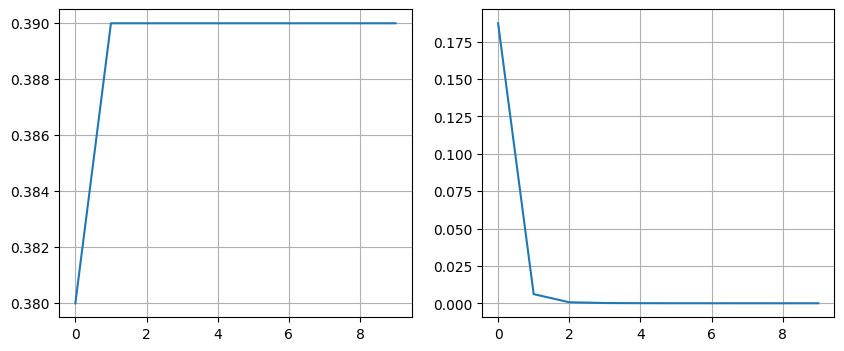

In [282]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(log[:,1])
plt.grid()
plt.subplot(122)
plt.plot(log[:,0])
plt.grid()
plt.show()

In [309]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np

class TextClassifier(nn.Module):
	def __init__(self, nbr_words, nbrclass, embedding) -> None:
		super(TextClassifier, self).__init__()
		self.embedding = self.__embedding(embedding)
		self.classifier = nn.Sequential(
			nn.Linear(nbr_words, 1024),
			nn.LeakyReLU(0.2),
			nn.Linear(1024, 256),
			nn.LeakyReLU(0.2),
			nn.Linear(256, nbrclass)
		)
	
	
	def forward(self, x):
		x = self.mean_embedding(x)
		return self.classifier(x)
	
	def __embedding(self, embedding):
		embedding.requires_grad = True
		return embedding

	def mean_embedding(self, x):
		x = self.embedding(x)
		x = torch.mean(x, dim=1)
		return x

class Corpus2:
	def __init__(self, text, label, mapping):
		self.x_file = text
		self.y_file = label
		self.x = []
		self.y = []
		self.word2id = mapping
		self.__read_data()
	
	def __read_data(self):
		with open(self.y_file) as f:
			for y in f:
				self.y.append(np.array(int(y.strip()), dtype="int32"))

		with open(self.x_file) as file:
			for line in file:
				line = line.strip().split()
				text = np.array([self.word2id[word] for word in line if len(word) > 2], dtype="int32")
				self.x.append(text)

class Corpus2Data(Dataset):
	def __init__(self, data, device):
		self.data = data
		self.device = device

	def __getitem__(self, idx):
		x = torch.from_numpy(self.data.x[idx]).long()
		y = torch.from_numpy(self.data.y[idx]).long()
		return x, y

	def __len__(self):
		return len(self.data.y)
	
def collate_fn(batch):
	# Separate the inputs and targets
	inputs, targets = zip(*batch)
	# Pad sequences
	inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
	# Stack targets
	targets = torch.stack(targets)
	return inputs, targets


def train(model, dataloader, num_epochs, criterion, optimizer, device):
	N = len(dataloader.dataset)
	log = []
	model.train()
	for epoch in range(num_epochs):
		total_loss = 0
		correct = 0
		pbar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}")
		for x, y in pbar:
			x, y = x.to(device), y.to(device)
			optimizer.zero_grad()
			output = model(x)
			loss = criterion(output, y)
			loss.backward()
			optimizer.step()

			total_loss += loss.item() * x.size(0)


			# Calculate accuracy
			_ , predicted = torch.max(output, 1)
			correct += (predicted == y).sum().item()

			pbar.set_postfix(loss=f"{total_loss/N:.2f}", accuracy=f"{correct/N:.2f}")

		avg_loss = total_loss / N
		accuracy = correct / N
		log.append((avg_loss, accuracy))

	model.eval()
	return model, log

In [310]:
device = "mps"
corpus2 = Corpus2(f"{DATA}/testing_data.txt", f"{DATA}/testing_data_label.txt", word2id)
corpus2train = Corpus2Data(corpus2,device)
corpus2loader = DataLoader(corpus2train, batch_size=16, shuffle=True, collate_fn=collate_fn)


classf = TextClassifier(model.center.embedding_dim, 4, model.center)
classf = classf.to(device)

optimizer = optim.NAdam(classf.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()

classf, log = train(classf, corpus2loader, 20,criterion, optimizer, device)

Epoch 20: 100%|██████████| 13/13 [00:00<00:00, 147.51it/s, accuracy=0.39, loss=0.00]
